In [32]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

# Random Forest Classifier

In [27]:
# Generate noisy multi-class classification data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, random_state=42, n_informative=10, n_redundant=5, flip_y=0.1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       106
           1       0.75      0.86      0.80        98
           2       0.75      0.69      0.72        96

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



Found high correlation between the following base model pairs (indices):
(0, 94)
(2, 4)
(2, 8)
(2, 17)
(2, 32)
(2, 45)
(2, 69)
(2, 86)
(2, 98)
(4, 14)
(4, 28)
(6, 16)
(6, 17)
(6, 19)
(6, 41)
(6, 51)
(6, 62)
(6, 63)
(6, 69)
(8, 98)
(9, 75)
(9, 79)
(9, 81)
(10, 17)
(11, 45)
(11, 59)
(11, 90)
(14, 37)
(14, 46)
(14, 68)
(14, 69)
(14, 73)
(14, 79)
(16, 17)
(16, 24)
(16, 34)
(16, 79)
(16, 91)
(16, 94)
(17, 23)
(17, 25)
(17, 41)
(17, 63)
(17, 69)
(17, 79)
(18, 28)
(19, 21)
(19, 22)
(21, 28)
(22, 88)
(25, 34)
(25, 41)
(25, 45)
(25, 82)
(25, 86)
(25, 87)
(28, 36)
(28, 65)
(31, 62)
(31, 70)
(32, 62)
(34, 62)
(34, 94)
(37, 88)
(41, 63)
(42, 70)
(42, 89)
(44, 53)
(44, 69)
(45, 88)
(46, 59)
(49, 86)
(51, 69)
(53, 59)
(54, 61)
(56, 63)
(56, 71)
(57, 59)
(57, 84)
(59, 62)
(59, 88)
(59, 94)
(61, 69)
(63, 79)
(65, 87)
(67, 91)
(69, 92)
(71, 73)
(76, 90)
(77, 79)
(77, 88)
(79, 82)
(82, 83)
(82, 99)
(83, 99)
(89, 98)
(95, 98)
(98, 99)


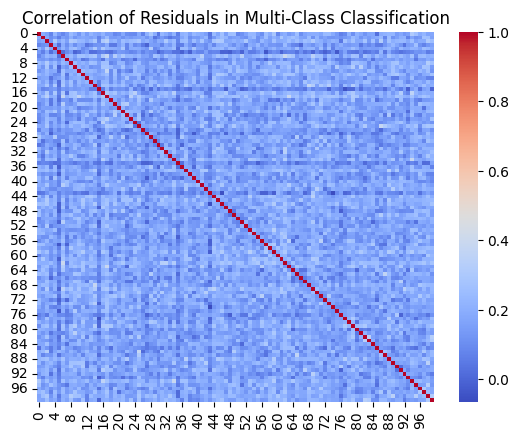

In [29]:
CORRELATED_TREES_THRESHOLD = 0.3

# Get predictions from each base model
base_model_preds = np.array([model.predict(X_test) for model in rf_clf.estimators_])

y_true_broadcasted_per_estimator = np.tile(y_test, (rf_clf.n_estimators,1))

# Compute misclassification residuals (1 if wrong, 0 if correct)
misclassifications = (base_model_preds != y_true_broadcasted_per_estimator).astype(int)

# Calculate the correlation matrix of the misclassifications
correlation_matrix = np.corrcoef(misclassifications)

high_correlation_pairs = np.where(np.abs(correlation_matrix) > CORRELATED_TREES_THRESHOLD)
high_correlation_pairs = [(i, j) for i, j in zip(*high_correlation_pairs) if i < j]

# Output the problematic pairs of base models
if high_correlation_pairs:
    print("Found high correlation between the following base model pairs (indices):")
    for pair in high_correlation_pairs:
        print(pair)
else:
    print("No significant correlation detected between the errors of the base models.")

sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Residuals in Multi-Class Classification')
plt.show()

# RandomForestRegressor

Mean Squared Error for Regression: 7365.2020


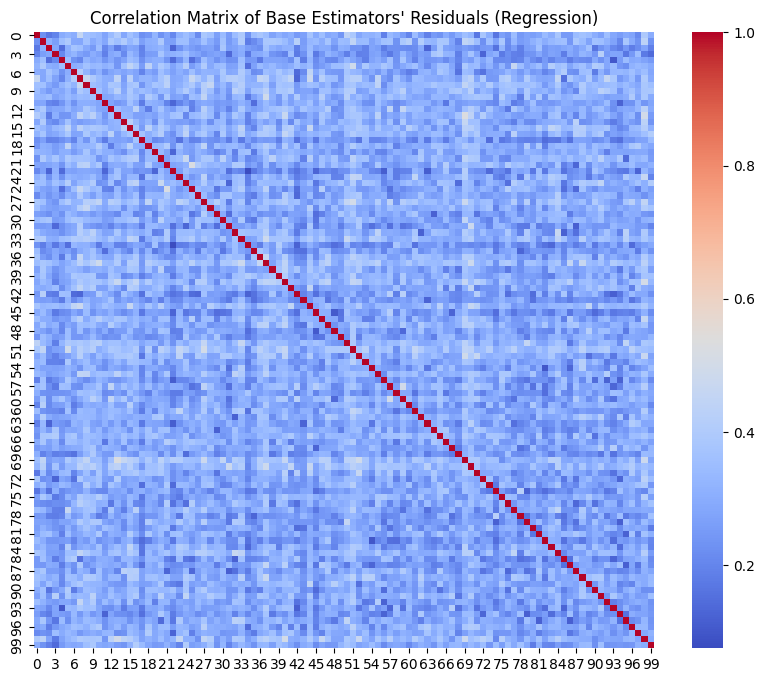

In [35]:
# Generate synthetic dataset with noise for regression
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, n_informative=10, random_state=42, noise=0.1)

# Split dataset
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Fit RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_reg = rf_reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Mean Squared Error for Regression: {mse:.4f}")

# Analyze the residuals (errors)
residuals_reg = y_pred_reg - y_test_reg

# Get residuals from individual trees (base estimators)
estimators = rf_reg.estimators_
base_estimators_predictions = np.array([estimator.predict(X_test_reg) for estimator in estimators]).T

# Calculate residuals for each base estimator
base_estimators_residuals = base_estimators_predictions - y_test_reg[:, None]

# Correlation matrix of residuals
base_estimators_residuals_correlation = np.corrcoef(base_estimators_residuals.T)

# Plotting the correlation matrix of base estimators' residuals
plt.figure(figsize=(10, 8))
sns.heatmap(base_estimators_residuals_correlation, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Base Estimators' Residuals (Regression)")
plt.show()